In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
from xgboost import plot_importance
from xgbtune import tune_xgb_model

import warnings
warnings.filterwarnings("ignore")

In [137]:
#import dataset
btc_df = pd.read_csv(r'Dataset\sentiment_btc_v2.csv', index_col=0)
eth_df = pd.read_csv(r'Dataset\sentiment_eth_v2.csv', index_col=0)
price_df = pd.read_csv(r'Dataset\Prices.csv', index_col=0)
btc_tweet_volume = pd.read_csv(r'Dataset\BTC_tweet_perday.csv', index_col=0, names=['Date','tweet_volume'], header=0)
eth_tweet_volume = pd.read_csv(r'Dataset\ETH_tweet_perday.csv', index_col=0, names=['Date','tweet_volume'], header=0)

In [138]:
#set date as Index
price_df = price_df['2020-01-01 00:00:00':'2021-01-01 00:00:00']
price_df.index = pd.to_datetime(price_df.index, utc=True)
price_df = price_df.sort_values(by='Date')
price_df.index = price_df.index.date
price_df.index.name = 'Date'

## *

In [139]:
def PreProc(df, volume_df, price_df=price_df):
    #df
    #set date as Index
    df['Date'] = pd.to_datetime(df['Date'], utc=False)
    df = df.set_index('Date')

    #prep df
    df = df.drop(columns='Tweet', axis=0)
    df = df.sort_values('Date')

    #formatting Index
    df.index = df.index.date
    df.index.name = 'Date'

    #create new features: Impact, classes
    df['Impact'] = 2*df['Retweet']*df['classes'] + df['Likes']*df['classes']
    df = pd.get_dummies(df, columns=['classes'])

    #volume_df
    #set date as Index
    volume_df['Date'] = pd.to_datetime(volume_df['Date'], utc=False)
    volume_df = volume_df.set_index('Date')

    #subsetting df
    volume_df = volume_df['2020-01-01 00:00:00':'2021-01-01 00:00:00']

    #formatting Index
    volume_df.index = volume_df.index.date
    volume_df.index.name = 'Date'

    #Handling missing value
    volume_df[volume_df.isnull()].sum()
    volume_df = volume_df.fillna(method='ffill')

    #merge all df
    merge_df = df.groupby('Date')[['Impact', 'classes_-1', 'classes_1']].sum()
    temp = df.groupby('Date')[['roberta_neg', 'roberta_neu', 'roberta_pos']].sum()
    merge_df = merge_df.merge(temp, on='Date')
    merge_df = pd.merge(merge_df, volume_df, on='Date')
    merge_df = pd.merge(merge_df, price_df, on='Date')
    
    return merge_df

In [140]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

In [141]:
def split_plot(train, test, crypto):
    fig, ax = plt.subplots(figsize=(17, 8))
    train[f'{crypto}_close'].plot(ax=ax, label='Training Set')
    test[f'{crypto}_close'].plot(ax=ax, label='Test Set')
    ax.axvline('2020-09-30', color='black', ls='--')
    ax.axvline('2020-10-01', color='black', ls='--')
    plt.legend()
    plt.title(crypto)
    plt.show()

In [142]:
def model(x_train, y_train, x_test, y_test):
    params = {'eval_metric': 'rmse'}
    params, round_count = tune_xgb_model(params,x_train, y_train)

    regressor=xgb.XGBRegressor(**params)

    regressor.fit(x_train, y_train)

    predictions = regressor.predict(x_test)

    #RMSLE = np.sqrt( mean_squared_log_error(y_test, predictions))
    RMSE = np.sqrt( mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test,predictions)
    #print("RMSLE score is %.5f" % RMSLE )
    print("RMSE score is %.5f" % RMSE)
    print("r2 score is %.5f" % r2)

    plt.rcParams.update({'font.size': 16})

    predictions = pd.DataFrame({'Date':x_test.index, 'pred':predictions})
    predictions['Date'] = pd.to_datetime(predictions['Date'], utc=False)
    predictions = predictions.set_index('Date')

    fig = plt.figure(figsize=(20, 5))
    sns.lineplot(data=y_test, color='r', label='actual', alpha=0.6)
    sns.lineplot(data=predictions, alpha=0.6)
    plt.show()

In [143]:
def CorrPlot(df, crypto):
    scaler = preprocessing.MinMaxScaler()

    scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    scaled_df.index = pd.to_datetime(df.index, utc=True)

    fig, axes = plt.subplots(4, 2, figsize=(36, 24), sharey=True)

    sns.lineplot(ax=axes[0, 0], data=scaled_df, y=f'{crypto}_close', x=scaled_df.index, label='Price')
    sns.lineplot(ax=axes[0, 0], data=scaled_df, y='roberta_neg', x=scaled_df.index, color='r', label='Negative Sentiment')
    axes[0, 0].set_title('roberta_neg')
    axes[0, 0].legend(loc='upper left')

    sns.lineplot(ax=axes[0, 1], data=scaled_df, y=f'{crypto}_close', x=scaled_df.index, label='Price')
    sns.lineplot(ax=axes[0, 1], data=scaled_df, y='roberta_neu', x=scaled_df.index, color='b', label='Neutral Sentiment')
    axes[0, 1].set_title('roberta_neu')
    axes[0, 1].legend(loc='upper left')


    sns.lineplot(ax=axes[1, 0], data=scaled_df, y=f'{crypto}_close', x=scaled_df.index, label='Price')
    sns.lineplot(ax=axes[1, 0], data=scaled_df, y='roberta_pos', x=scaled_df.index, color='g', label='Positive Sentiment')
    axes[1, 0].set_title('roberta_pos')
    axes[1, 0].legend(loc='upper left')

    sns.lineplot(ax=axes[1, 1], data=scaled_df, y=f'{crypto}_close', x=scaled_df.index, label='Price')
    sns.lineplot(ax=axes[1, 1], data=scaled_df, y=f'{crypto} Volume', x=scaled_df.index, color='y', label='Volume')
    axes[1, 1].set_title(f'{crypto} Volume')
    axes[1, 1].legend(loc='upper left')

    sns.lineplot(ax=axes[2, 0], data=scaled_df, y=f'{crypto}_close', x=scaled_df.index, label='Price')
    sns.lineplot(ax=axes[2, 0], data=scaled_df, y='tweet_volume', x=scaled_df.index, color='purple', label='Tweet Volume')
    axes[2, 0].set_title('tweet_volume')
    axes[2, 0].legend(loc='upper left')

    sns.lineplot(ax=axes[2, 1], data=scaled_df, y=f'{crypto}_close', x=scaled_df.index, label='Price')
    sns.lineplot(ax=axes[2, 1], data=scaled_df, y='Impact', x=scaled_df.index, color='black', label='Impact')
    axes[2, 1].set_title('Impact')
    axes[2, 1].legend(loc='upper left')

    sns.lineplot(ax=axes[3, 0], data=scaled_df, y=f'{crypto}_close', x=scaled_df.index, label='Price')
    sns.lineplot(ax=axes[3, 0], data=scaled_df, y='classes_1', x=scaled_df.index, color='g', label='classes_1')
    axes[3, 0].set_title('classes_1')
    axes[3, 0].legend(loc='upper left')

    sns.lineplot(ax=axes[3, 1], data=scaled_df, y=f'{crypto}_close', x=scaled_df.index, label='Price')
    sns.lineplot(ax=axes[3, 1], data=scaled_df, y='classes_-1', x=scaled_df.index, color='r', label='classes_-1')
    axes[3, 1].set_title('classes_-1')
    axes[3, 1].legend(loc='upper left')

    plt.show()

## **

In [144]:
btc_merge = PreProc(btc_df, btc_tweet_volume)
btc_merge = btc_merge.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 13]]
btc_merge.head()

,Impact,classes_-1,classes_1,roberta_neg,roberta_neu,roberta_pos,tweet_volume,+1D BTC,Price Diff BTC,BTC Volume,BTC_close
Date,,,,,,,,,,,
2020-01-01,14142,11.0,41.0,13.432412,35.412087,42.155501,13987.0,0,-214.704392,1.856566e+10,7200.174393
2020-01-02,14141,13.0,34.0,16.989382,38.617619,35.392998,15920.0,1,359.414183,2.080208e+10,6985.470001
2020-01-03,25399,15.0,50.0,16.566883,41.624191,48.808926,19730.0,1,65.772383,2.811148e+10,7344.884183
2020-01-04,9496,11.0,24.0,12.361318,28.269648,24.369032,16357.0,1,0.660760,1.844427e+10,7410.656566
2020-01-05,18747,16.0,27.0,17.012711,36.276232,28.711057,16533.0,1,357.901712,1.972507e+10,7411.317327


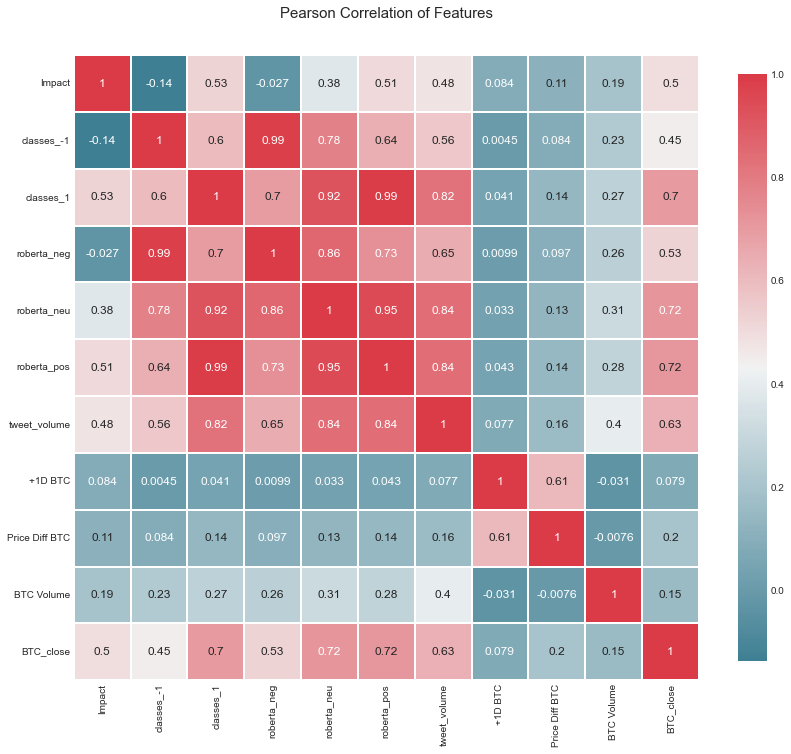

In [145]:
correlation_heatmap(btc_merge)

In [146]:
eth_merge = PreProc(eth_df, eth_tweet_volume)
eth_merge = eth_merge.iloc[:, [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 14]]
eth_merge.head()

,Impact,classes_-1,classes_1,roberta_neg,roberta_neu,roberta_pos,tweet_volume,+1D ETH,Price Diff ETH,ETH Volume,ETH_close
Date,,,,,,,,,,,
2020-01-01,4255,6,14,6.701138,15.148669,16.150193,2161.0,0,-3.391826,7.935230e+09,130.802008
2020-01-02,9203,4,21,6.006404,15.207750,20.785846,3019.0,1,6.761530,8.032709e+09,127.410182
2020-01-03,1228,12,15,12.083549,21.996594,15.919856,2750.0,1,0.897659,1.047685e+10,134.171712
2020-01-04,5093,1,14,3.152349,13.243627,12.604023,2250.0,1,1.207405,7.430905e+09,135.069371
2020-01-05,6856,6,11,6.964404,14.396745,12.638852,2321.0,1,8.027377,7.526675e+09,136.276777


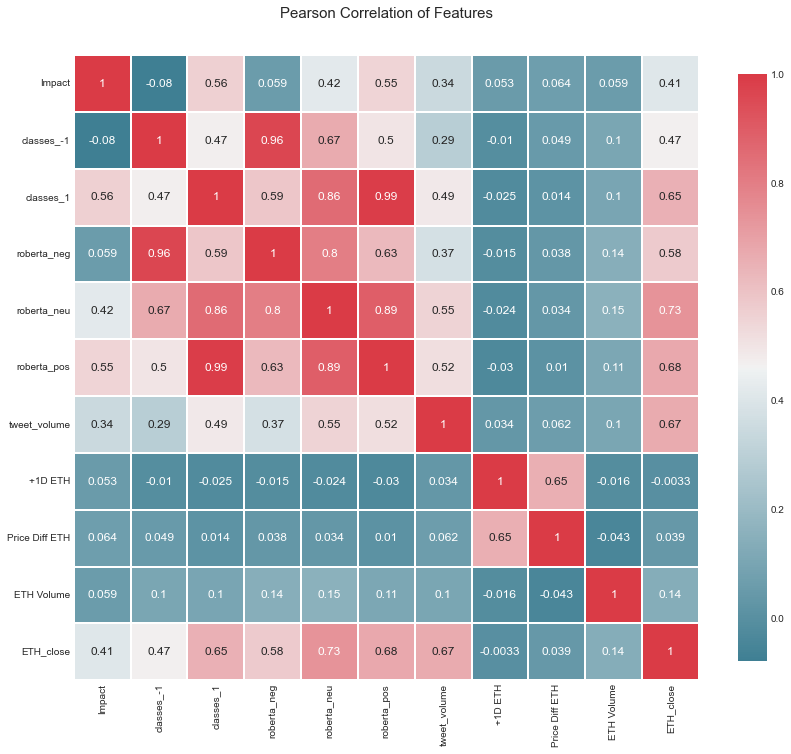

In [147]:
correlation_heatmap(eth_merge)

## **-

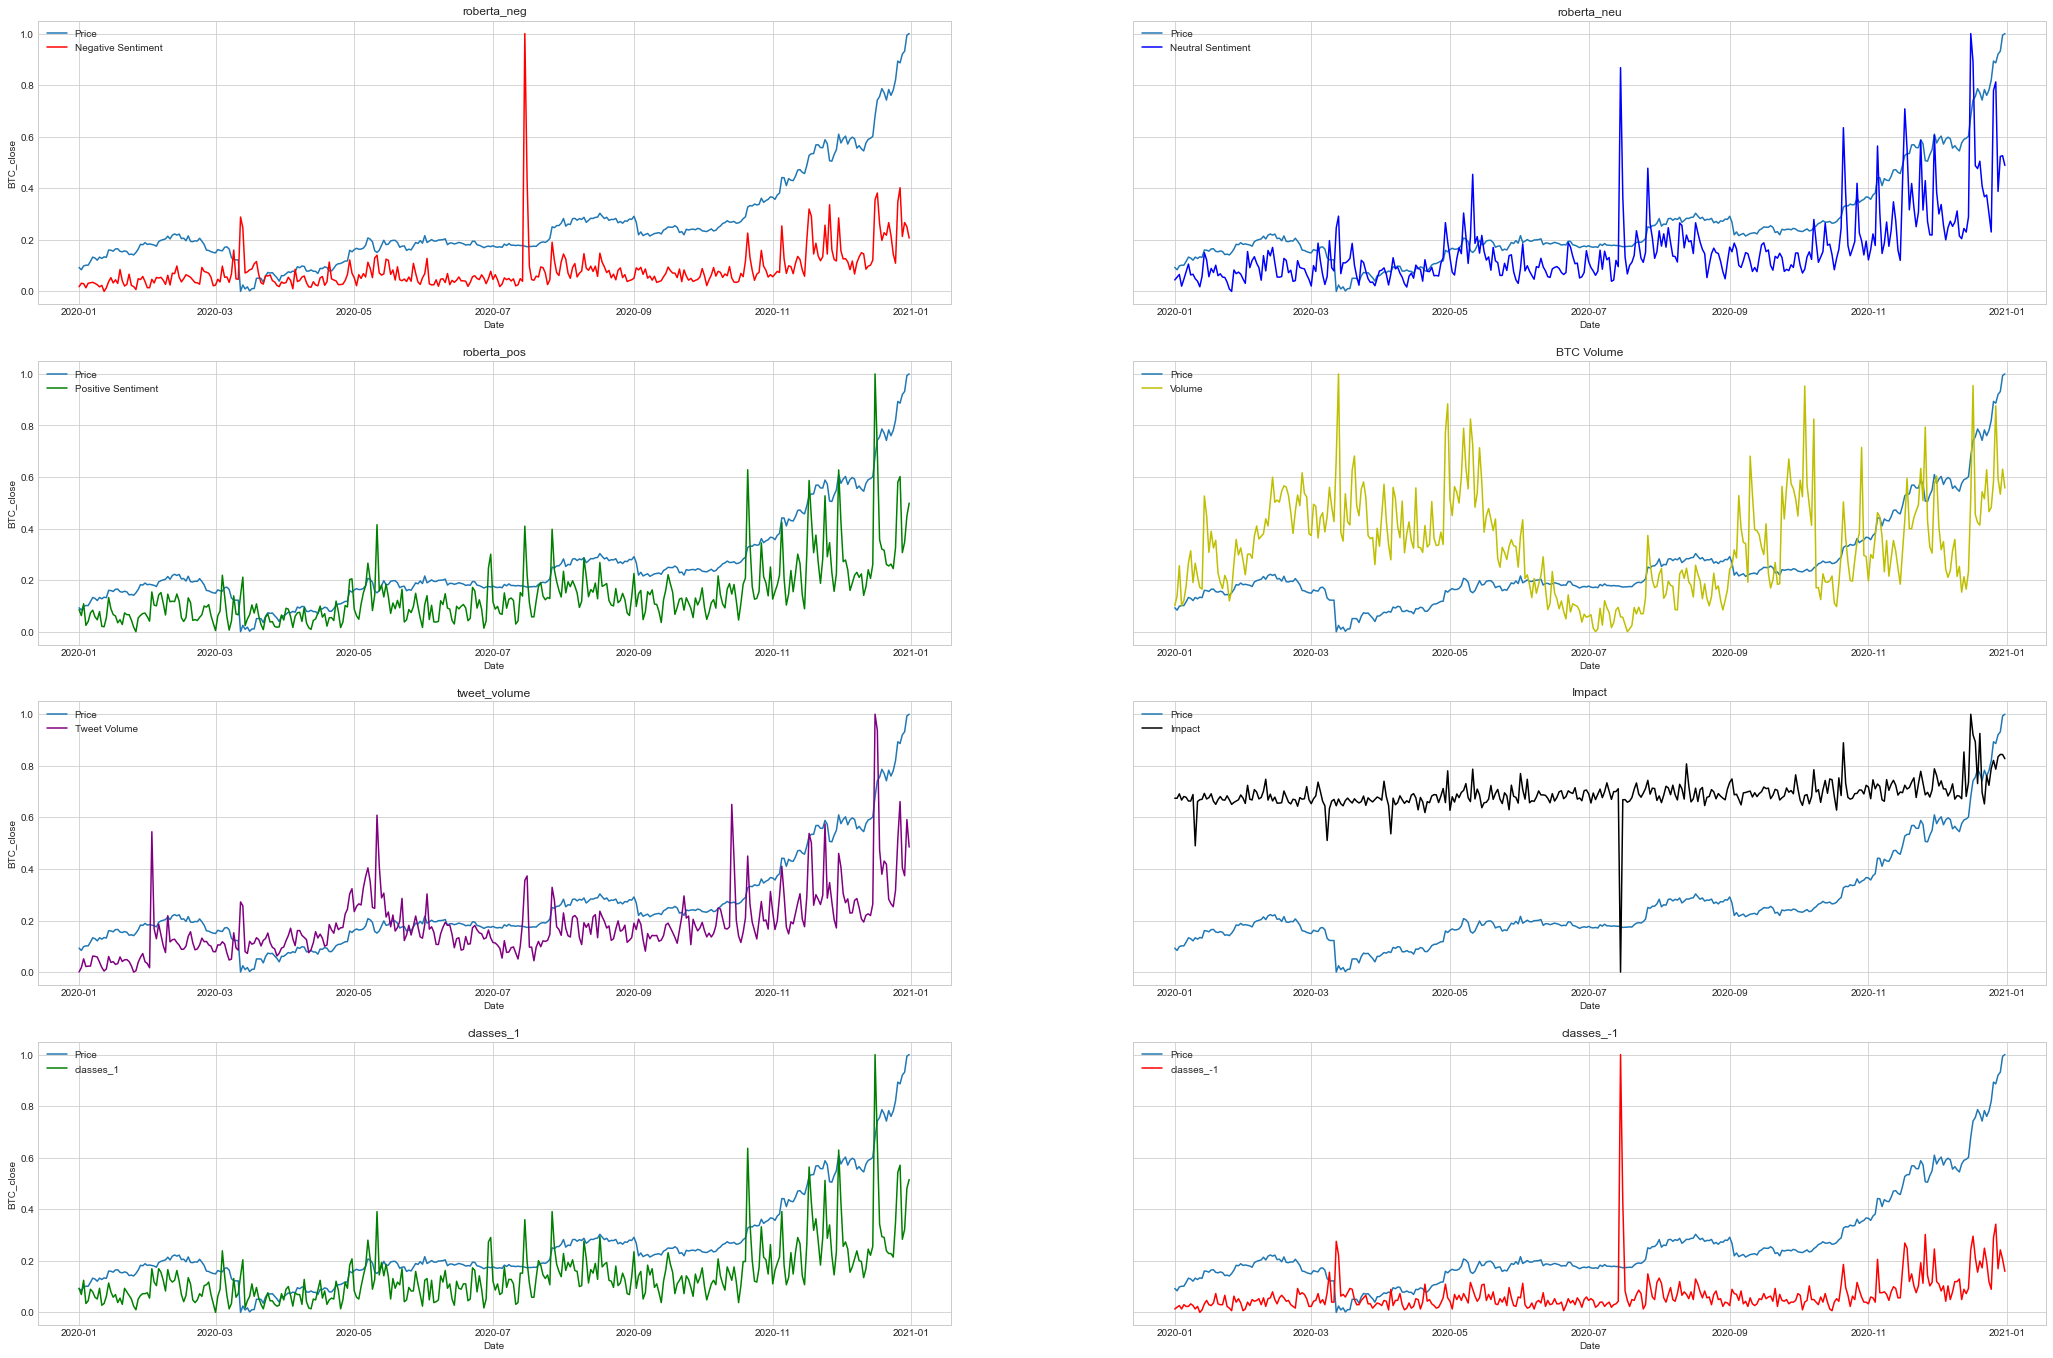

In [148]:
CorrPlot(btc_merge, 'BTC')

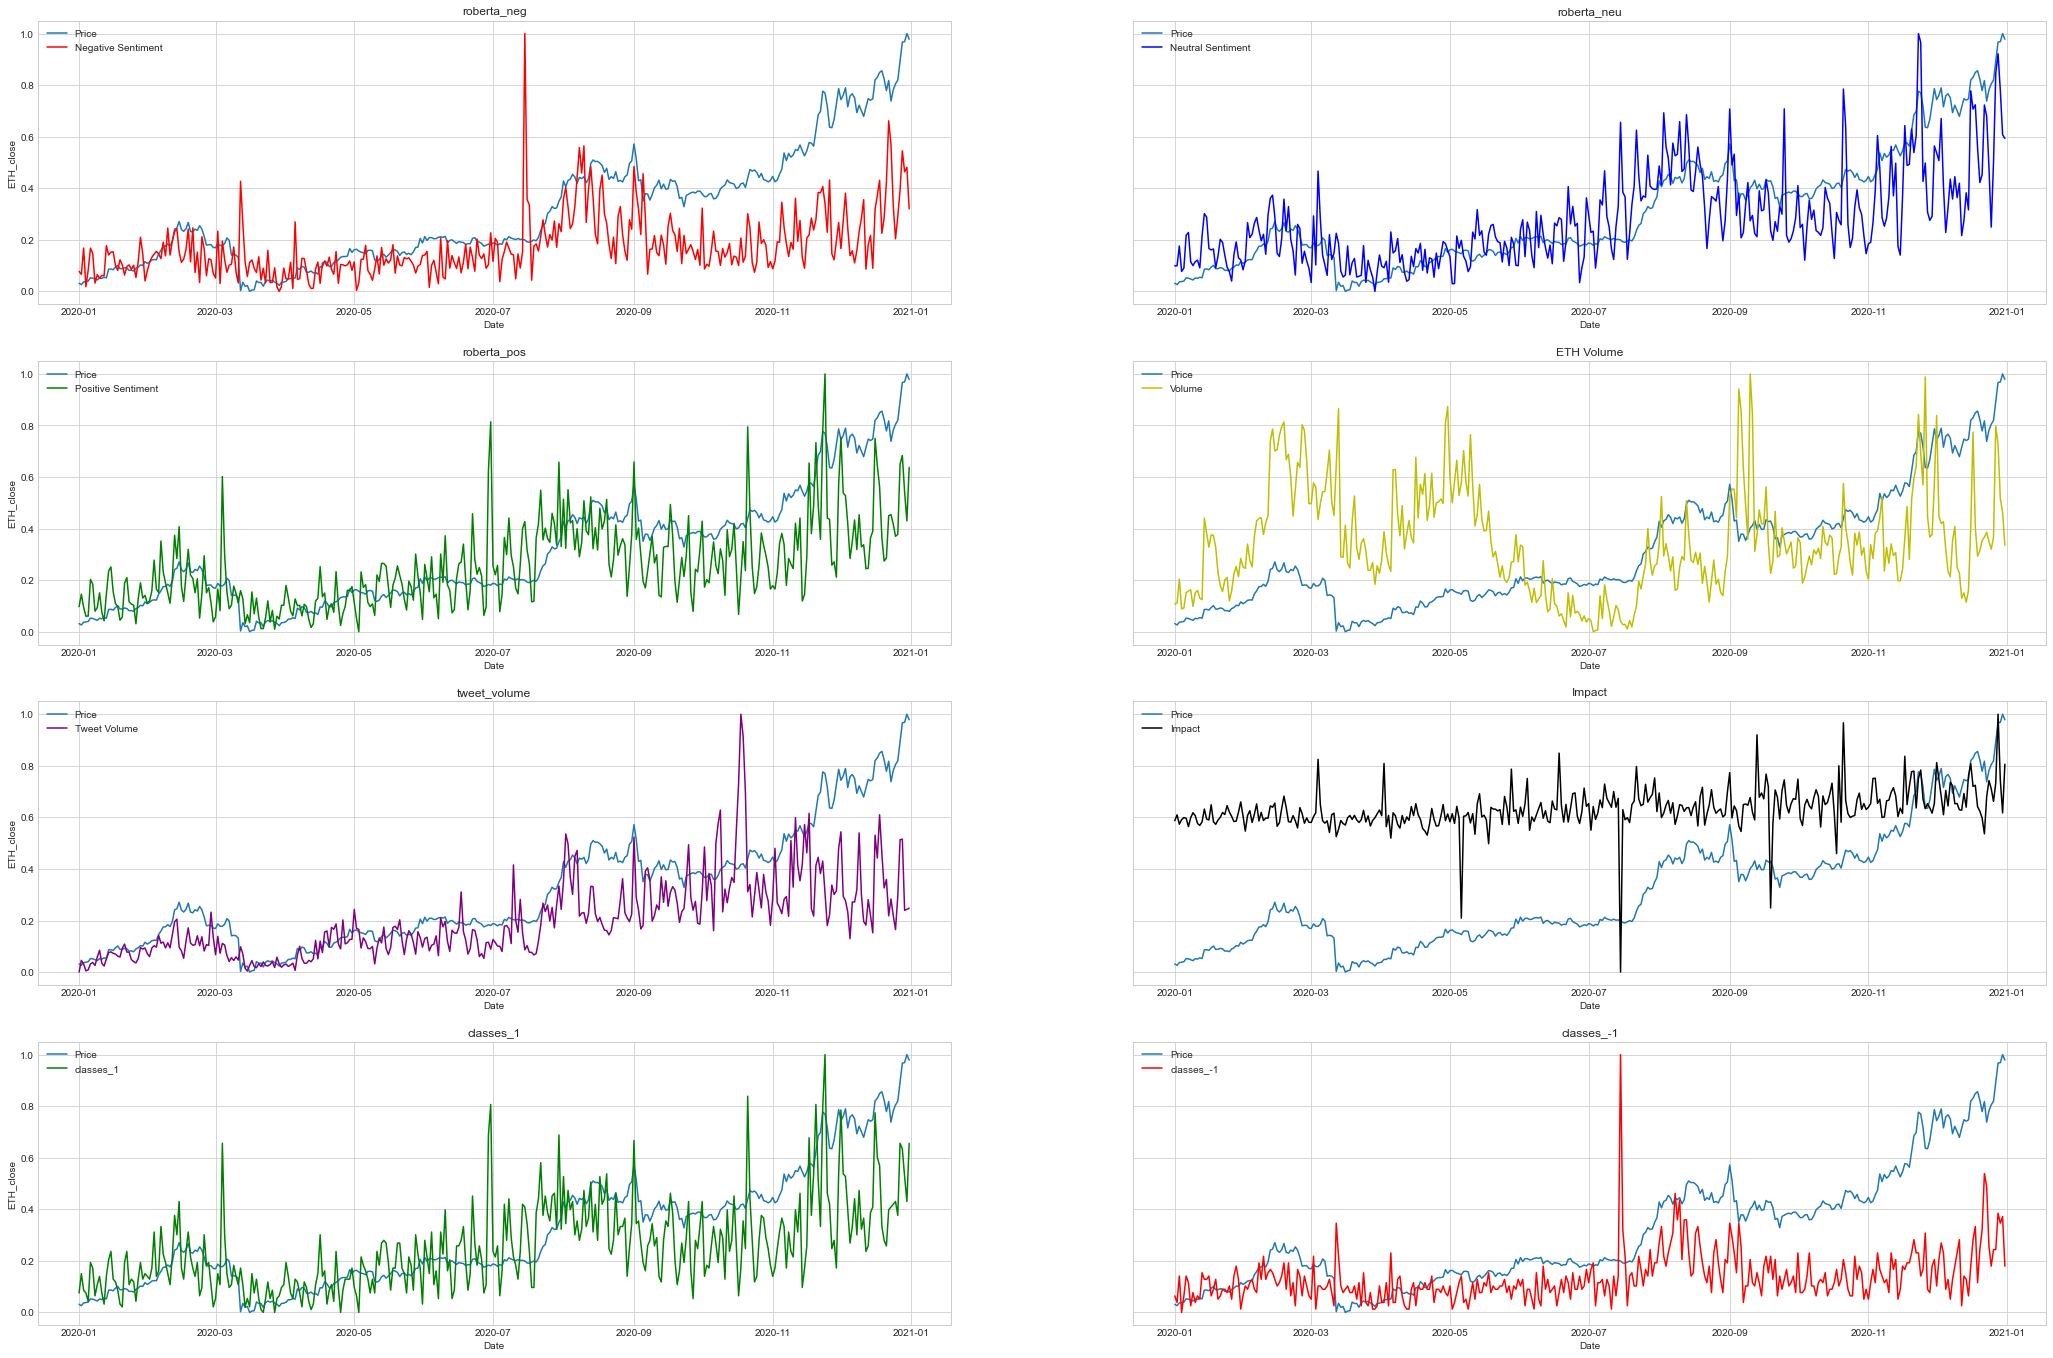

In [149]:
CorrPlot(eth_merge, 'ETH')

## ***

In [150]:
date1 = pd.to_datetime('2020-09-30').date()
date2 = pd.to_datetime('2020-10-01').date()

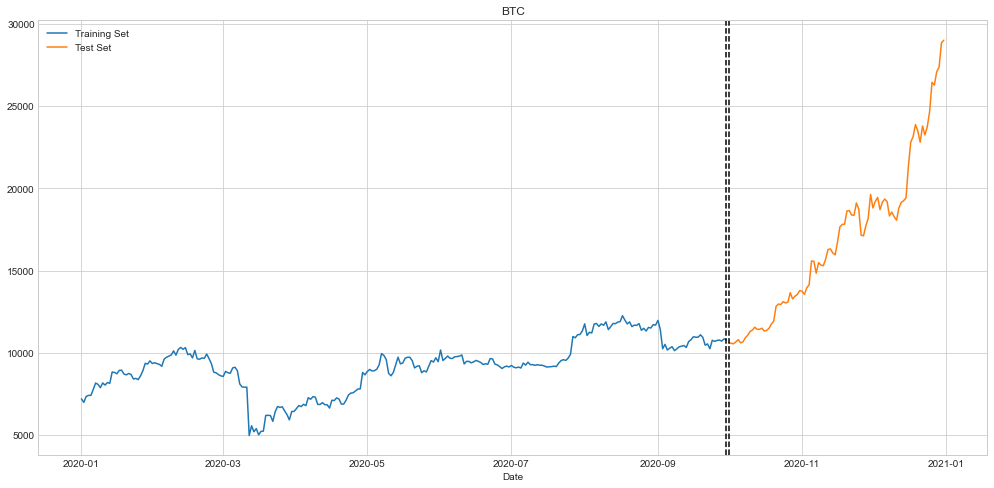

In [151]:
train_btc = btc_merge[:date1]
test_btc = btc_merge[date2:]
split_plot(train_btc, test_btc, 'BTC')
#test_btc = btc_merge

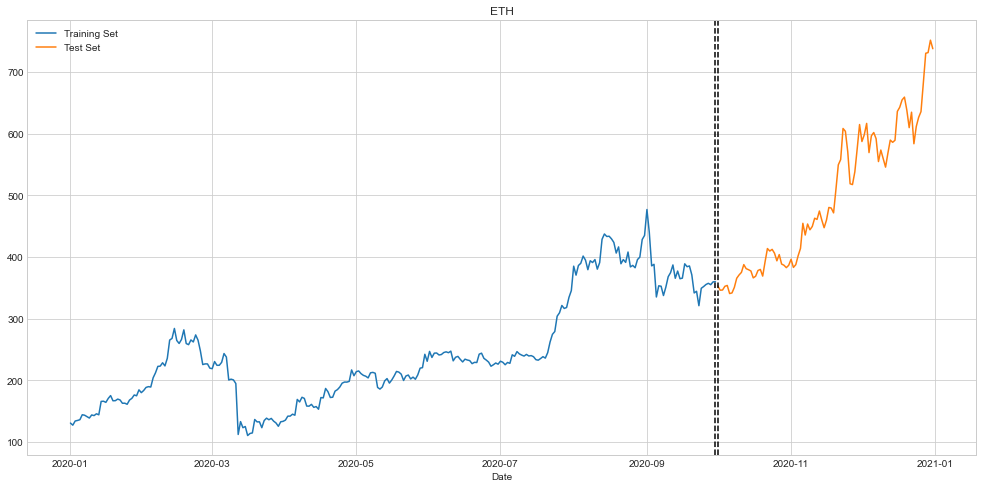

In [152]:
train_eth = eth_merge[:date1]
test_eth = eth_merge[date2:]
split_plot(train_eth, test_eth, 'ETH')
#test_eth = eth_merge

## XGBoost

In [153]:
eth_merge.head()

,Impact,classes_-1,classes_1,roberta_neg,roberta_neu,roberta_pos,tweet_volume,+1D ETH,Price Diff ETH,ETH Volume,ETH_close
Date,,,,,,,,,,,
2020-01-01,4255,6,14,6.701138,15.148669,16.150193,2161.0,0,-3.391826,7.935230e+09,130.802008
2020-01-02,9203,4,21,6.006404,15.207750,20.785846,3019.0,1,6.761530,8.032709e+09,127.410182
2020-01-03,1228,12,15,12.083549,21.996594,15.919856,2750.0,1,0.897659,1.047685e+10,134.171712
2020-01-04,5093,1,14,3.152349,13.243627,12.604023,2250.0,1,1.207405,7.430905e+09,135.069371
2020-01-05,6856,6,11,6.964404,14.396745,12.638852,2321.0,1,8.027377,7.526675e+09,136.276777


In [154]:
x_train_btc = train_btc.drop(['BTC_close', 'Impact', 'Price Diff BTC', 'BTC Volume'], axis=1) 
y_train_btc = train_btc['Price Diff BTC']
x_test_btc = test_btc.drop(['BTC_close', 'Impact', 'Price Diff BTC', 'BTC Volume'], axis=1) 
y_test_btc = test_btc['Price Diff BTC']

x_train_eth = train_eth.drop(['Impact','ETH_close', 'Price Diff ETH', 'ETH Volume'], axis=1) 
y_train_eth = train_eth['Price Diff ETH']
x_test_eth = test_eth.drop(['Impact','ETH_close', 'Price Diff ETH', 'ETH Volume'], axis=1) 
y_test_eth = test_eth['Price Diff ETH']

tuning pass 0...
computing best round...
best round: 2
tuning max_depth and min_child_weight ...
best loss: 216.55
best max_depth: 8
best min_child_weight: 1
tuning gamma ...
best loss: 216.55
best gamma: 0.0
re-computing best round...
best round: 2
tuning subsample and colsample_bytree ...
best loss: 216.55
best subsample: 1.0
best colsample_bytree: 1.0
fine tuning subsample and colsample_bytree ...
best loss: 216.55
best subsample: 1.0
best colsample_bytree: 1.0
tuning alpha and lambda ...
best loss: 216.55
best alpha: 0
best lambda: 1
tuning seed ...
best loss: 216.55
best seed: 0
{'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.0, 'subsample': 1.0, 'colsample_bytree': 1.0, 'alpha': 0, 'lambda': 1, 'seed': 0}
tuning pass 1...
computing best round...
best round: 2
tuning max_depth and min_child_weight ...
best loss: 216.55
best max_depth: 8
best min_child_weight: 1
tuning gamma ...
best loss: 216.55
best gamma: 0.0
re-computing best round...
best round: 2
tun

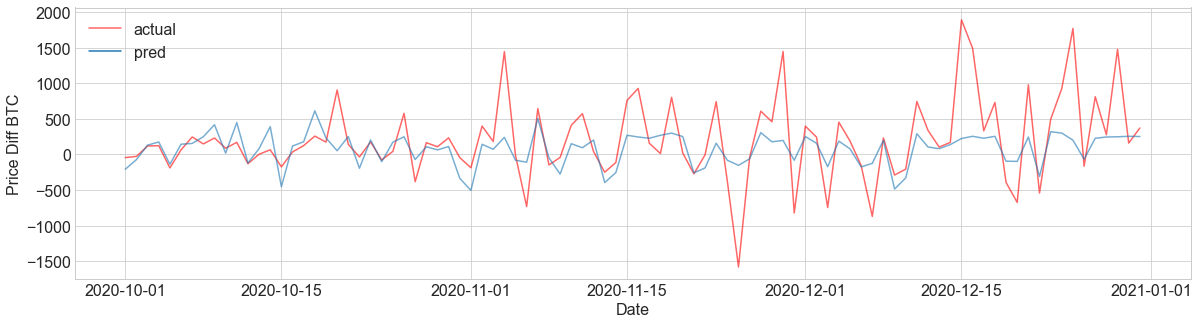

In [155]:
model(x_train_btc, y_train_btc, x_test_btc, y_test_btc)

In [156]:
x_train_eth.columns

Index(['classes_-1', 'classes_1', 'roberta_neg', 'roberta_neu', 'roberta_pos',
       'tweet_volume', '+1D ETH'],
      dtype='object')

tuning pass 0...
computing best round...
best round: 3
tuning max_depth and min_child_weight ...
best loss: 6.8355
best max_depth: 8
best min_child_weight: 1
tuning gamma ...
best loss: 6.8355
best gamma: 0.0
re-computing best round...
best round: 3
tuning subsample and colsample_bytree ...
best loss: 6.8355
best subsample: 1.0
best colsample_bytree: 1.0
fine tuning subsample and colsample_bytree ...
best loss: 6.8355
best subsample: 1.0
best colsample_bytree: 1.0
tuning alpha and lambda ...
best loss: 6.8355
best alpha: 0
best lambda: 1
tuning seed ...
best loss: 6.8355
best seed: 0
{'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.0, 'subsample': 1.0, 'colsample_bytree': 1.0, 'alpha': 0, 'lambda': 1, 'seed': 0}
tuning pass 1...
computing best round...
best round: 3
tuning max_depth and min_child_weight ...
best loss: 6.8355
best max_depth: 8
best min_child_weight: 1
tuning gamma ...
best loss: 6.8355
best gamma: 0.0
re-computing best round...
best round: 3
tun

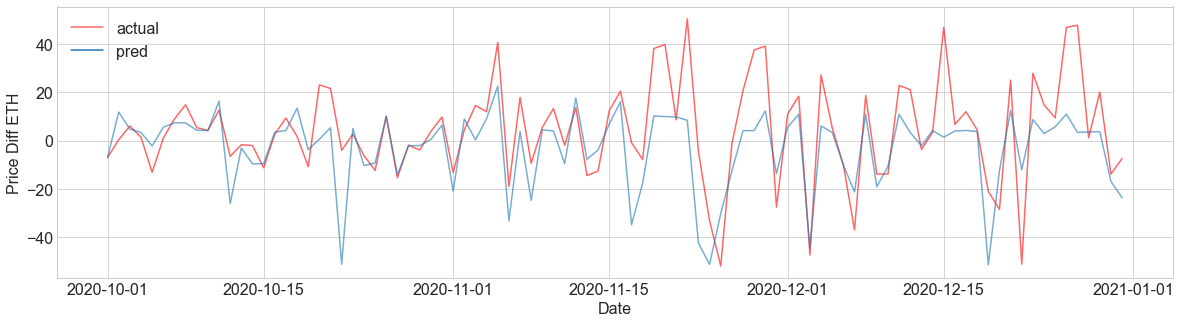

In [157]:
model(x_train_eth, y_train_eth, x_test_eth, y_test_eth)